In [140]:
library(tidyverse)
library(geometry)

df <- read_csv("fig/landscape_throughput/throughput.csv")

ch <- convhulln(cbind(df$x, df$y))

library(plotly)

Parsed with column specification:
cols(
  x = col_double(),
  y = col_double(),
  ARI = col_double(),
  Q = col_double(),
  Q_AON = col_double(),
  Q_D = col_double(),
  Q_DW = col_double(),
  kind = col_character()
)



Warning message:
“Using size for a discrete variable is not advised.”


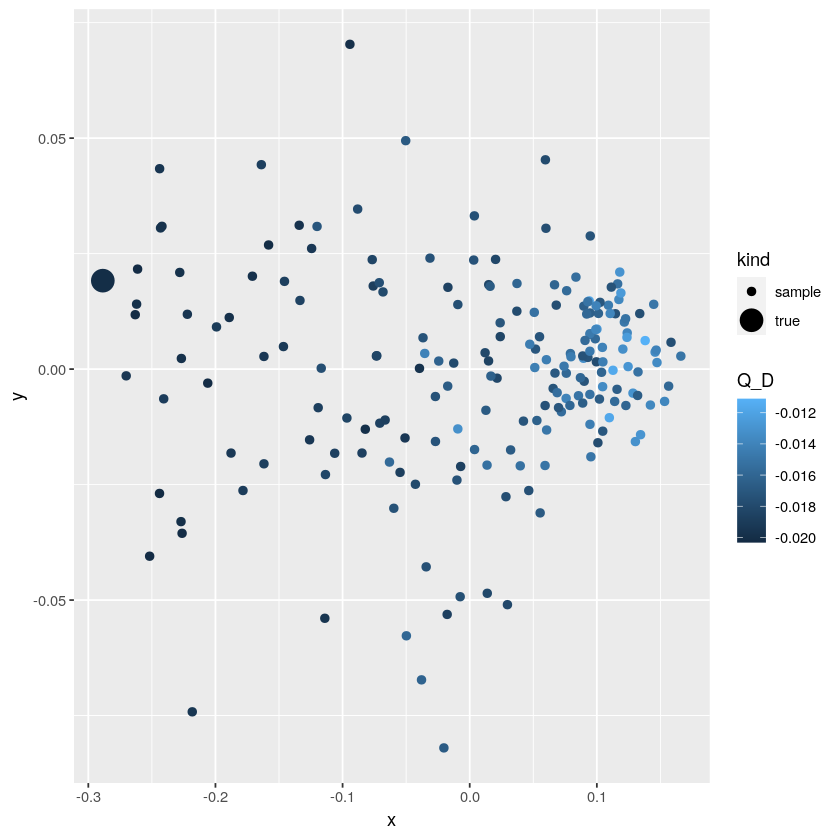

In [141]:
df %>% 
#     filter(x < 0) %>% 
    ggplot() + 
    aes(x = x, y = y, color = Q_D, size = kind) +
    geom_point() 

In [134]:
grid <- expand.grid(x = seq(min(df$x), max(df$x), by = 0.0005), y = seq(min(df$y), max(df$y), by = 0.0002), stringsAsFactors = FALSE) %>% 
    tibble()

grid["in_grid"] <- inhulln(ch, cbind(grid$x, grid$y)) 
    
long_df <- df %>% 
    pivot_longer(cols = contains("Q"), names_to = "Q") %>% 
    ungroup()

In [135]:
loess_preds <- function(Q_type = "Q"){
    sub_df <- long_df %>%
        filter(Q == Q_type) 
    
    fit <- loess(value ~ x + y, data = sub_df, span = .8)
    
    broom::augment(fit, newdata = data.frame(grid)) %>% 
        mutate(z = .fitted, Q_type = Q_type)
}

preds_df <- c("Q", "Q_AON", "Q_D", "Q_DW") %>% 
    map(loess_preds) %>% 
    reduce(rbind) %>%
    mutate(z = ifelse(in_grid, z, NA))

In [130]:
# preds_df <- preds_df %>% 
#     group_by(x, y) %>% 
#     filter(sum(is.na(z)) == 0)

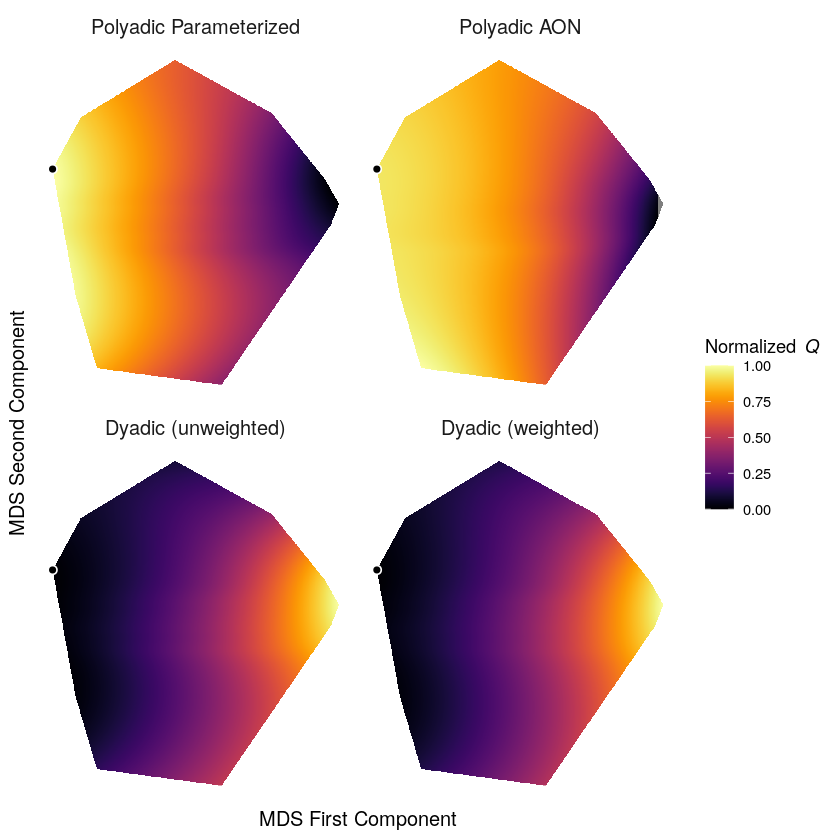

In [131]:
true_partitions <- df %>% 
    filter(kind == "true")

levels <- c("Polyadic Parameterized", "Polyadic AON", "Dyadic (unweighted)", "Dyadic (weighted)")
preds_df %>% 
    filter(in_grid) %>% 
    group_by(Q_type) %>% 
    mutate(Q_type = case_when(Q_type == "Q"     ~ "Polyadic Parameterized", 
                              Q_type == "Q_AON" ~ "Polyadic AON", 
                              Q_type == "Q_D"   ~ "Dyadic (unweighted)", 
                              Q_type == "Q_DW"  ~ "Dyadic (weighted)", 
                              )) %>% 
    mutate(Q_type = factor(Q_type, levels = levels)) %>% 
    mutate(z = (z - min(z, na.rm = T))/(max(z, na.rm = T) - min(z, na.rm = T))) %>% 
    ggplot() + 
    aes(x = x, y = y) + 
    geom_raster(aes(fill = z)) + 
    facet_wrap(~Q_type) + 
    geom_point(data = true_partitions, pch = 21, fill = "black", color = "white", size = 2, stroke = .7) + 
    viridis::scale_fill_viridis(option = "inferno") + 
    theme_bw() + 
    guides(fill = guide_colorbar(title = expression("Normalized"~italic(Q)))) +
    theme(strip.background = element_blank(),
          panel.border = element_blank(),
          axis.ticks = element_blank(),
          axis.text = element_blank(),
          strip.text = element_text(size = 12),
          panel.grid = element_blank(), 
          axis.title = element_text(size = 12)) + 
    xlab("MDS First Component") + 
    ylab("MDS Second Component")

In [74]:
ggsave("fig/committee_mds.png", width = 9, height = 7)